In [47]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import tensorflow as tf
from tensorflow.keras import layers

In [48]:
class GridWorld():
    def __init__(self):
        self.state = self.init_state()
        self.step_count = 0

    def init_state(self):
        xs = random.sample(range(0, 7), 5)
        ys = random.sample(range(0, 7), 5)
        piece1 = (xs[0], ys[0])
        playerpos = (xs[4], ys[4])
        positions = list(np.array([playerpos, piece1]).flatten())
        return positions
    
    def reset(self):
        self.state = self.init_state()
        self.step_count = 0
        return self.state
    
    def step(self, action):
        self.step_count += 1
        if action == 0:
            self.state[1] += 1
        elif action == 1:
            self.state[0] += 1
        elif action == 2:
            self.state[1] -= 1
        elif action == 3:
            self.state[0] -= 1
        
        if self.step_count >= 25:
            self.reset()
            reward = int(rewarder(tf.expand_dims(self.state, 0), training=False)[0])
            playing = False
            return reward, playing
        if (self.state[0] == self.state[2] and self.state[1] == self.state[3]):
            playing = False
            reward = int(rewarder(tf.expand_dims(self.state, 0), training=False)[0])
            self.reset()
            return reward, playing
        
        playing = True
        reward = int(rewarder(tf.expand_dims(self.state, 0), training=False)[0])
        return reward, playing
    
class Actor(tf.keras.Model):
    def __init__(self, num_actions, num_hidden_units):
        super().__init__()
        self.shared_1 = layers.Dense(num_hidden_units, activation='relu')
        self.actor = layers.Dense(num_actions)
    
    def call(self, inputs):
        x = self.shared_1(inputs)
        return self.actor(x)
    
class Critic(tf.keras.Model):
    def __init__(self, num_hidden_units):
        super().__init__()
        self.shared_1 = layers.Dense(num_hidden_units, activation='relu')
        self.reward = layers.Dense(1)
    
    def call(self, inputs):
        x = self.shared_1(inputs)
        return self.reward(x)

In [49]:
def calc_g(rewards, gamma):
    ez_discount = np.array([gamma**i for i in range(len(rewards))])
    gs = []
    rewards = np.array(rewards)
    for ts in range(len(rewards)):
        to_end_reward = rewards[ts:]
        eq_len_discount = ez_discount[:len(to_end_reward)]
        g = np.multiply(to_end_reward, eq_len_discount).sum()
        gs.append(g)
    return gs

def step_episode(S, model):
    S.reset()
    action_probs_list = []
    rewards = []
    states = []
    actions = []
    playing = True
    while playing:
        obs = tf.expand_dims(S.state, 0)
        action_logits = model(obs)
        selected_action_idx = tf.random.categorical(action_logits, 1)[0, 0]
        states.append(obs)
        actions.append(selected_action_idx)
        reward, playing = S.step(selected_action_idx)
        action_probs = tf.nn.softmax(action_logits)
        probability_of_selected_action = action_probs[0, selected_action_idx]
        action_probs_list.append(probability_of_selected_action)
        rewards.append(reward)
    return action_probs_list, rewards, states, actions

def actor_loss(action_probs, rewards, states):
    g = calc_g(rewards, 0.99)
    action_probs = tf.convert_to_tensor(action_probs, dtype=tf.float32)
    loss = -tf.math.reduce_sum(action_probs * g)
    return loss

def decode_action(action):
    if action == 0:
        return "up"
    elif action == 1:
        return "right"
    elif action == 2:
        return "down"
    elif action == 3:
        return "left"

def compare(transition_ids, states, actions):
    d1xs = [states[transition_ids[0]][0][0], states[transition_ids[0]][0][2]]
    d1ys = [states[transition_ids[0]][0][1], states[transition_ids[0]][0][3]]
    d2xs = [states[transition_ids[1]][0][0], states[transition_ids[1]][0][2]]
    d2ys = [states[transition_ids[1]][0][1], states[transition_ids[1]][0][3]]

    _, ax = plt.subplots(1, 2, figsize=(6, 3))
    colors = ['b', 'r']
    markers = ['o', 'X']
    for i in range(2):
        ax[0].scatter(d1xs[i], d1ys[i], c=colors[i], marker=markers[i])
        ax[1].scatter(d2xs[i], d2ys[i], c=colors[i], marker=markers[i])
    ax[0].set_title(str(decode_action(actions[transition_ids[0]].numpy())))
    ax[1].set_title(str(decode_action(actions[transition_ids[1]].numpy())))
    plt.show()



def preference_update(states, actions, rewarder, optimizer):
    transition_ids = random.sample(range(len(states)-2), 2)
    compare(transition_ids, states, actions)
    pref = input("Select the better transition || q:left, d:right, s:same")
    if pref == "q":
        dist = [1, 0]
    elif pref == "d":
        dist = [0, 1]
    elif pref == "s":
        dist = [1, 1]
    
    with tf.GradientTape() as tape:
        reward1 = rewarder(states[transition_ids[0] + 1])
        reward2 = rewarder(states[transition_ids[1] + 1])
        p1 = tf.nn.softmax(reward1)
        p2 = tf.nn.softmax(reward2)
        loss = -p1 * dist[0] - p2 * dist[1]
    grads = tape.gradient(loss, rewarder.trainable_variables)
    optimizer.apply_gradients(zip(grads, rewarder.trainable_variables))
    

In [50]:
agent = Actor(num_actions=4, num_hidden_units=128)
rewarder = Critic(num_hidden_units=128)
S = GridWorld()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

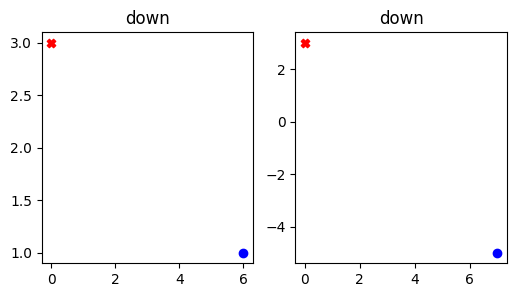

UnboundLocalError: cannot access local variable 'dist' where it is not associated with a value

In [51]:
average_len = []
for episode in range(1000):
    with tf.GradientTape() as tape:
        action_probs, rewards, states, actions = step_episode(S, agent)
        loss = actor_loss(action_probs, rewards, states)
    grads = tape.gradient(loss, agent.trainable_variables)
    optimizer.apply_gradients(zip(grads, agent.trainable_variables))
    average_len.append(len(rewards))
    preference_update(states, actions, rewarder, optimizer)

    print("Episode: {}, Length: {}".format(episode, len(rewards)))
    print("Average Length: {}".format(statistics.mean(average_len[-100:])))